In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Permute
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D
from keras.layers import MaxPooling1D, Conv1D
from keras.layers import GRU, LSTM, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Flatten, Reshape, Dropout
from keras.utils import to_categorical
from keras.layers import Activation
from keras import regularizers

from sklearn.metrics import confusion_matrix

from UtilNNDL import create_window_data
from UtilNNDL import plot_hist
from UtilNNDL import prepare_data
from UtilNNDL import plot_confusion_matrix
from UtilNNDL import bandpass_cnt
from UtilNNDL import exponential_running_standardize

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Using TensorFlow backend.


In [2]:
#Prepare the data by taking out nans and dividing into test and train
file_path = 'datasets/'
file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
train_data, test_data, train_labels, test_labels = prepare_data(file_path, 
                                                                num_test_samples = 50, 
                                                                verbose= False, 
                                                                return_all=True,
                                                                num_files =1)
print train_data.shape
print train_labels.shape
print test_data.shape
print test_labels.shape

(237, 22, 1000)
(237, 4)
(50, 22, 1000)
(50, 4)


In [3]:
#assist numerical stability
train_data = train_data*(1e6)
test_data = test_data*(1e6)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2)
print train_data.shape
print test_data.shape
for i,a in enumerate(train_data):
    train_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)
for i,a in enumerate(test_data):
    test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
print train_data.shape
print test_data.shape

(237, 1000, 22)
(50, 1000, 22)
(237, 1000, 22)
(50, 1000, 22)


In [4]:
#Standardize the data
for i,a in enumerate(train_data):
    train_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
for i,a in enumerate(test_data):
    test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2) 
print train_data.shape
print test_data.shape

(237, 22, 1000)
(50, 22, 1000)


In [5]:
#Augment the data into a bigger set by windowing
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=10)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)
print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape 

(2370, 22, 512)
(2370, 4)
(500, 22, 512)
(500, 4)


In [6]:
test_data_sliced = test_data_sliced[:500,:]
test_labels_sliced = test_labels_sliced[:500,:]
print test_data_sliced.shape
print test_labels_sliced.shape 

(500, 22, 512)
(500, 4)


In [7]:
traindata2d = train_data_sliced.reshape(train_data_sliced.shape[0], train_data_sliced.shape[2], train_data_sliced.shape[1], 1)
testdata2d = test_data_sliced.reshape(test_data_sliced.shape[0], test_data_sliced.shape[2], test_data_sliced.shape[1], 1)
print traindata2d.shape
print testdata2d.shape

(2370, 512, 22, 1)
(500, 512, 22, 1)


# TESTING


deepconvnet no regularization

In [8]:
num_filters = 15
model = Sequential()
model.add(Conv2D(num_filters, kernel_size=(num_filters,1), activation='relu', data_format='channels_last', input_shape=(traindata2d.shape[1], traindata2d.shape[2], traindata2d.shape[3])))  
model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu') ) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*2, kernel_size=(10,num_filters), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*4, kernel_size=(10,num_filters*2), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*8, kernel_size=(10,num_filters*4), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Reshape((num_filters*8,1)))
#model.add(LSTM(100, return_sequences=True))
#model.add(LSTM(32))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(traindata2d,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=32)
#model.test_on_batch(test_data, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 22, 15)       240       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 484, 8, 15)        50640     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 161, 8, 15)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 161, 15, 8)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 152, 1, 30)        36030     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 1, 30)         0         
_________________________________________________________________
permute_2 (Permute)          (None, 50, 30, 1)         0         
__________

ResourceExhaustedError: OOM when allocating tensor with shape[32,15,498,22] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/conv2d_2/convolution_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@conv2d_2/convolution"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/conv2d_2/convolution_grad/ShapeN, conv2d_2/kernel/read, training/Adam/gradients/conv2d_2/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op u'training/Adam/gradients/conv2d_2/convolution_grad/Conv2DBackpropInput', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/carla/Documents/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-5e7fbd85b2fd>", line 28, in <module>
    hist = model.fit(traindata2d,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=32)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/models.py", line 963, in fit
    validation_steps=validation_steps)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/engine/training.py", line 1689, in fit
    self._make_train_function()
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/optimizers.py", line 440, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 2512, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 609, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 375, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 609, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_grad.py", line 499, in _Conv2DGrad
    data_format=data_format),
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 817, in conv2d_backprop_input
    dilations=dilations, name=name)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op u'conv2d_2/convolution', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 18 identical lines from previous traceback]
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-5e7fbd85b2fd>", line 4, in <module>
    model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu') )
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/models.py", line 492, in add
    output_tensor = layer(self.outputs[0])
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 3332, in conv2d
    data_format=tf_data_format)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 754, in convolution
    return op(input, filter)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 838, in __call__
    return self.conv_op(inp, filter)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 502, in __call__
    return self.call(inp, filter)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 190, in __call__
    name=self.name)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 639, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,15,498,22] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/conv2d_2/convolution_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@conv2d_2/convolution"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/conv2d_2/convolution_grad/ShapeN, conv2d_2/kernel/read, training/Adam/gradients/conv2d_2/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



500/500 [==============================] - 0s 437us/step
Test Score: [1.8094149484634399, 0.51200000000000001]


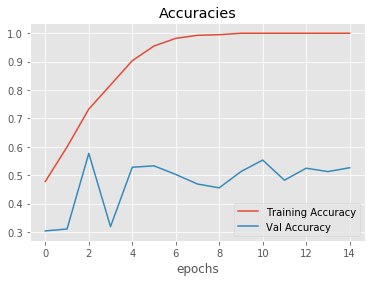

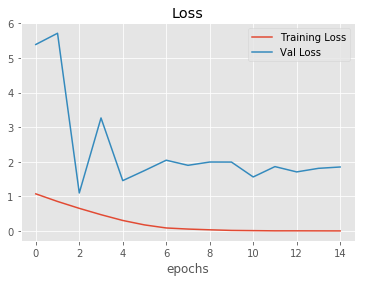

In [17]:
test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=32)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

Trying out:
    * X batchnorm before nonlinearity
    * X regularization
    * dropout 0.5 applied to inputs to conv layers after the first
    * “new tied loss function” for further regularization

In [15]:
num_filters = 15 #15 performs similar
model = Sequential()
model.add(Conv2D(num_filters, kernel_size=(num_filters,1), data_format='channels_last', input_shape=(traindata2d.shape[1], traindata2d.shape[2], traindata2d.shape[3]), kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))  
model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal') ) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.55))

model.add(Conv2D(num_filters*2, kernel_size=(10,num_filters), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.55))

model.add(Conv2D(num_filters*4, kernel_size=(10,num_filters*2), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.55))

model.add(Conv2D(num_filters*8, kernel_size=(10,num_filters*4), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Reshape((num_filters*8,1)))
#model.add(LSTM(32, return_sequences=True))

model.add(Flatten())
model.add(Dense(4, activation='softmax', kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(traindata2d,train_labels_sliced,epochs=45,validation_split=0.25,batch_size=32)
#model.test_on_batch(test_data, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 498, 22, 15)       240       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 484, 8, 15)        50640     
_________________________________________________________________
batch_normalization_13 (Batc (None, 484, 8, 15)        60        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 161, 8, 15)        0         
_________________________________________________________________
permute_10 (Permute)         (None, 161, 15, 8)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 161, 15, 8)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 152, 1, 30)        36030     
__________

1777/1777 [==============================] - 2s 1ms/step - loss: 0.4349 - acc: 0.8205 - val_loss: 1.1643 - val_acc: 0.6189
Epoch 38/45
1777/1777 [==============================] - 2s 1ms/step - loss: 0.4480 - acc: 0.8081 - val_loss: 1.2026 - val_acc: 0.5379
Epoch 39/45
1777/1777 [==============================] - 2s 1ms/step - loss: 0.4407 - acc: 0.8272 - val_loss: 1.1456 - val_acc: 0.5767
Epoch 40/45
1777/1777 [==============================] - 2s 1ms/step - loss: 0.4542 - acc: 0.8053 - val_loss: 1.0060 - val_acc: 0.5902
Epoch 41/45
1777/1777 [==============================] - 2s 1ms/step - loss: 0.4256 - acc: 0.8301 - val_loss: 1.3553 - val_acc: 0.5902
Epoch 42/45
1777/1777 [==============================] - 2s 1ms/step - loss: 0.4395 - acc: 0.8171 - val_loss: 1.1620 - val_acc: 0.6020
Epoch 43/45
1777/1777 [==============================] - 2s 1ms/step - loss: 0.3947 - acc: 0.8334 - val_loss: 1.2310 - val_acc: 0.6003
Epoch 44/45
1777/1777 [==============================] - 2s 1ms/ste

500/500 [==============================] - 0s 393us/step
Test Score: [1.0608434863090515, 0.62399999952316287]


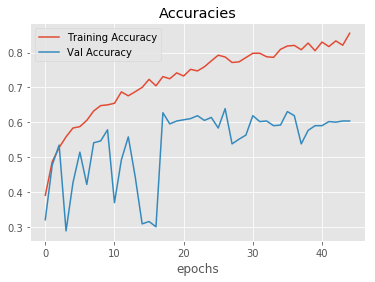

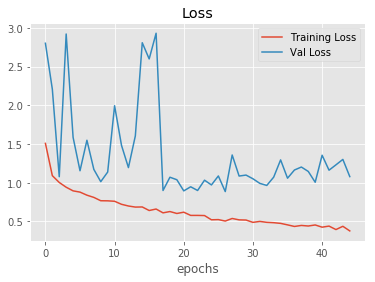

[130 120 130 120]
Confusion matrix, without normalization
[[ 73  49   7   1]
 [ 16 100   4   0]
 [  3  17  53  57]
 [ 10   2  22  86]]


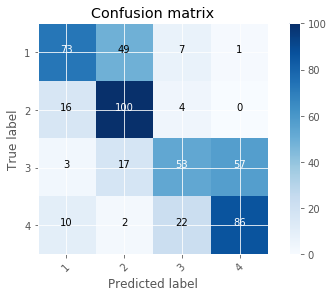

In [16]:
test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=32)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

test_predict = model.predict(testdata2d, batch_size=32)
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
unique, count = np.unique(np.argmax(test_labels_sliced,axis=1),return_counts=True)
print count 
plt.figure(0)
plot_confusion_matrix(cm, classes=["1","2","3","4"])

In [20]:
#np.save('Best Models/Variables/DeepConvNet_hist_A10T.npy', hist.history)
#np.save('Best Models/Variables/DeepConvNet_conf_A10T.npy', cm)
#np.save('Best Models/Variables/DeepConvNet_testacc_A10T.npy', test_score)

np.load('Best Models/Variables/DeepConvNet_testacc_A10T.npy')

array([ 1.06084349,  0.624     ])